In [1]:
import numpy as np
import os, datetime
from glob import glob
import re

import pytorch_lightning as pl
from torch import nn
import torch
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)

import torch.distributions as tfd
from tqdm import tqdm
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_device('cuda')

import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

from scipy.stats import norm
import matplotlib.pyplot as plt
import h5py, corner
from scipy.interpolate import interp1d

from matplotlib import rcParams
rcParams.update({'font.size': 12})

/home/dbreitman/.conda/envs/pytorch_env/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/home/dbreitman/.conda/envs/pytorch_env/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrast

In [2]:
import os
import urllib.request
from urllib.error import HTTPError

import lightning as L
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from lightning.pytorch.callbacks import Callback, LearningRateMonitor, ModelCheckpoint
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from tqdm.notebook import tqdm

%matplotlib inline
matplotlib.rcParams["lines.linewidth"] = 2.0


# Tensorboard extension (for visualization purposes later)
%load_ext tensorboard

# Setting the seed
L.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Global seed set to 42


Device: cuda:0


In [3]:
from pathlib import Path
import os

In [4]:
path = '/projects/cosmo_database/dbreitman/CV_PS/Full_May2023_DB/'

In [5]:
import sys
sys.path.insert(1, '/home/dbreitman')
from dani_utils.plotting import imshow_error_2D, plot_hist
from dani_utils.test_funcs import Normalize, diag_cov

In [182]:
f = np.load(path + 'sept_db_90_thetas_wlog.npz')
seeds = f['PS_2D_seeds']
means = f['PS_2D_means']
zs = f['redshifts']
kperp = f['kperp']
kpar = f['kpar']
std_seeds = f['PS_2D_stds']
std_means = f['PS_2D_std_means']
std_poisson = f['poisson_stds']
ps_data = np.append(seeds[...,np.newaxis], means[...,np.newaxis], axis = -1)
print(ps_data.shape)
N_samples = ps_data.shape[0]
shape1 = (ps_data.shape[0] * ps_data.shape[1], ps_data.shape[2], ps_data.shape[3], 2)
ps_data = ps_data.reshape(shape1)
std_means = std_means.reshape(shape1[:-1])
std_poisson = std_poisson.reshape(shape1[:-1])
print(ps_data.shape)

(11784, 16, 16, 16, 2)
(188544, 16, 16, 2)


In [183]:
1/(std_means**2).min()

10000.0

In [184]:
#bias = 1e-8
#floor = 1e-8
noisy_norm = Normalize(ps_data[...,0], log = False, axis = 0)
noisy, noisy_mean, noisy_std = noisy_norm.get_normed_data()

mean_norm = Normalize(ps_data[...,1], log = False, axis = 0)
mean, mean_mean, mean_std = mean_norm.get_normed_data()

std_std = np.std(std_means, axis = 0)
std = std_means / std_std

In [212]:
(std).min()

0.018640647545835175

In [186]:
std.min(), std.max()

(0.018640647545835175, 14.569299255908856)

In [187]:
(((std) * std_std)**2).min(), (((std) * std_std)**2).max()

(9.999999999999996e-05, 46.903037210254766)

In [188]:

#poisson_std_norm = Normalize(std_poisson, log = True, axis = 0, floor = floor, bias = bias)
#poisson_std, poisson_std_mean, poisson_std_std = poisson_std_norm.get_normed_data()

mean_mean = torch.Tensor(mean_mean).to(DEVICE).float()
mean_std = torch.Tensor(mean_std).to(DEVICE).float()

#noisy_mean = torch.Tensor(noisy_mean).to(DEVICE).float()
#noisy_std = torch.Tensor(noisy_std).to(DEVICE).float()

std_std = torch.Tensor(std_std).to(DEVICE).float()

#poisson_std_mean = torch.Tensor(poisson_std_mean).to(DEVICE).float()
#poisson_std_std = torch.Tensor(poisson_std_std).to(DEVICE).float()

In [189]:
std.shape

(188544, 16, 16)

In [190]:
f_train = 0.6
f_valid = 1 - f_train

print(mean.min(), mean.max())
print(std.min(), std.max())

outputs_1 = np.append(mean[...,np.newaxis], std[...,np.newaxis], axis = -1)
#outputs_2 = np.append(noisy[...,np.newaxis], poisson_std[...,np.newaxis], axis = -1)

N_train = int(np.round(std.shape[0] * f_train))
N_valid = int(np.round(std.shape[0] * f_valid))

# shuffle
idx = np.arange(std.shape[0])
np.random.shuffle(idx)

outputs_1 = outputs_1[idx] # Mean + std
#outputs_2 = outputs_2[idx] # noisy + poisson

features = noisy[idx] # Noisy
#outputs = np.append(normed_dataset[...,1][...,np.newaxis], normed_covar[...,np.newaxis],axis = -1) # Mean and covar
#features[np.isnan(features)] = 0.
print('Training set size: ', N_train)
print('Validation set size:', N_valid)

X_train = features[:N_train]
X_valid = features[N_train:N_train+N_valid]

Y_train = outputs_1[:N_train]
Y_valid = outputs_1[N_train:N_train+N_valid]

#Y_train_id = outputs_2[:N_train]
#Y_valid_id = outputs_2[N_train:N_train+N_valid]

print(X_valid.shape)

-3.501439367194377 1.7137849769953948
0.018640647545835175 14.569299255908856
Training set size:  113126
Validation set size: 75418
(75418, 16, 16)


In [11]:
foo = noisy
print(foo.min(), foo.max())

-3.67447219674431 1.8332728131578133


In [46]:
batch_size = 128
name = 'Oct16'
model_path = '/home/dbreitman/CV_PS_denoising/Oct_models/AEs/'

In [35]:
class ResNet(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module

    def forward(self, inputs):
        return self.module(inputs) + inputs

class Encoder(nn.Module):
    def __init__(self, num_input_channels: int, base_channel_size: int, latent_dim: int, act_fn: object = nn.LeakyReLU, slope: float = 1e-2):
        """
        Args:
           num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.slope = slope
        self.act_fn = act_fn
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, stride=2),  # 16x16 => 7x7
            act_fn(c_hid),
            nn.BatchNorm2d(c_hid),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, stride=2), # 7x7 => 3x3
            act_fn(c_hid),
            nn.BatchNorm2d(c_hid),
        )
        
        self.resblock = ResNet(nn.Sequential(nn.Conv2d(c_hid, c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(c_hid),
                                    nn.BatchNorm2d(c_hid),
                                    nn.Conv2d(c_hid, c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(c_hid),
                                    nn.BatchNorm2d(c_hid),
        ))
        self.latent = nn.Sequential(nn.Flatten(),  # Image grid to single feature vector
                                    nn.Linear(c_hid * 3 * 3, latent_dim),
                                    act_fn(latent_dim),
        )
    def init_weights(self, m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.kaiming_uniform_(m.weight, a = np.sqrt(5.))
            fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(m.weight)
            if fan_in != 0:
                bound = 1e-3#1 / np.sqrt(fan_in)
                torch.nn.init.uniform_(m.bias, -bound, bound)
                
    def forward(self, x):
        #self.net.apply(self.init_weights)
        #self.resblock.apply(self.init_weights)
        #self.latent.apply(self.init_weights)
        y = self.net(x)
        y = self.resblock(y)
        y = self.resblock(y)
        #y = self.resblock(y)
        #y = self.resblock(y)
        #y = self.resblock(y)
        y = self.latent(y)
        return y
    

class Decoder(nn.Module):
    def __init__(self, 
                 num_input_channels: int, 
                 num_output_channels: int, 
                 base_channel_size: int, 
                 latent_dim: int, 
                 slope: float = 1e-2,
                 act_fn: object = nn.LeakyReLU):
        """
        Args:
           num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        n = 64
        self.slope = slope
        self.act_fn = act_fn
        self.linear = nn.Sequential(nn.Linear(latent_dim, n * 16 * c_hid), 
                                    act_fn(n * 16 * c_hid),
                                    nn.Linear(n * 16 * c_hid, n * 16 * c_hid), 
                                    act_fn(n * 16 * c_hid),
                                    nn.Linear(n * 16 * c_hid, n * 16 * c_hid), 
                                    act_fn(n * 16 * c_hid),
                                    nn.Linear(n * 16 * c_hid, n * 16 * c_hid), 
                                    act_fn(n * 16 * c_hid),
                                    nn.Linear(n * 16 * c_hid, n * 16 * c_hid), 
                                    act_fn(n * 16 * c_hid),
                                   )
        self.resblock = ResNet(nn.Sequential(nn.Conv2d(n * c_hid, n * c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(n * c_hid),
                                    nn.BatchNorm2d(n * c_hid),
                                    nn.Conv2d(n * c_hid, n * c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(n * c_hid),
                                    nn.BatchNorm2d(n * c_hid),
        ))
        self.net = nn.Sequential(
            nn.ConvTranspose2d(n * c_hid, n * c_hid, kernel_size=3, stride=1),  # 4x4 => 6x6
            act_fn(n * c_hid),
            #nn.BatchNorm2d(n * c_hid),
            #nn.Conv2d(32, 2 * c_hid, kernel_size=3), #6x6 -> 4x4
            #act_fn(),
            nn.ConvTranspose2d(n * c_hid, n * c_hid, kernel_size=2, stride=2),  # 4x4 => 7x7
            act_fn(n * c_hid),
            #nn.BatchNorm2d(n * c_hid),
            nn.ConvTranspose2d(n * c_hid, n * c_hid, kernel_size=3, stride = 1), #7x7 => 14x14
            act_fn(n * c_hid),
            #nn.BatchNorm2d(n * c_hid),
            nn.ConvTranspose2d(n * c_hid, num_output_channels, kernel_size=3, stride = 1), #14x14 => 16x16
        )
    def init_weights(self, m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.kaiming_uniform_(m.weight, a = np.sqrt(5.))
            fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(m.weight)
            if fan_in != 0:
                bound = 1e-3#1 / np.sqrt(fan_in)
                torch.nn.init.uniform_(m.bias, -bound, bound)
    def forward(self, x):
        #self.linear.apply(self.init_weights)
        #self.resblock.apply(self.init_weights)
        #self.net.apply(self.init_weights)
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.resblock(x)
        x = self.resblock(x)
        #x = self.resblock(x)
        #x = self.resblock(x)
        #x = self.resblock(x)
        x = self.net(x)
        #x = torch.cat((x[:,0,...][:, np.newaxis,...], nn.LeakyReLU()(x[:,1,...])[:, np.newaxis,...]), 1)
        return x

class Autoencoder(nn.Module):
    def __init__(
        self,
        base_channel_size: int,
        latent_dim: int,
        encoder_class: object = Encoder,
        decoder_class: object = Decoder,
        num_input_channels: int = 1,
        num_output_channels: int = 1,
        width: int = 16,
        height: int = 16,
        slope: float = 1e-2,
        act_fn: object = nn.LeakyReLU
    ):
        super().__init__()
        # Saving hyperparameters of autoencoder
        #self.save_hyperparameters()
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim, slope = slope, act_fn = act_fn)
        self.decoder = decoder_class(num_input_channels, num_output_channels, num_input_channels, latent_dim, slope = slope, act_fn = act_fn)


    def forward(self, x):
        """The forward function takes in an image and returns the reconstructed image."""
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

In [240]:
class ResNet(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module

    def forward(self, inputs):
        return self.module(inputs) + inputs

class Encoder(nn.Module):
    def __init__(self, num_input_channels: int, base_channel_size: int, latent_dim: int, act_fn: object = nn.LeakyReLU):
        """
        Args:
           num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=2, stride=2),  # 16x16 => 8x8
            act_fn(),
            nn.BatchNorm2d(c_hid),
            nn.Conv2d(c_hid, c_hid, kernel_size=2, stride=2), # 8x8 => 4x4
            act_fn(),
            nn.BatchNorm2d(c_hid),
            #nn.Conv2d(c_hid, c_hid, kernel_size=2, stride=2), # 4x4 => 2x2
            #act_fn(),
            #nn.BatchNorm2d(c_hid),
        )
        
        self.resblock = ResNet(nn.Sequential(nn.Conv2d(c_hid, c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(),
                                    #nn.BatchNorm2d(c_hid),
                                    nn.Conv2d(c_hid, c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(),
                                    #nn.BatchNorm2d(c_hid),
        ))
        self.latent = nn.Sequential(nn.Flatten(),  # Image grid to single feature vector
                                    nn.Linear(c_hid * 4 ** 2, latent_dim),
                                    act_fn(),
        )

    def forward(self, x):
        y = self.net(x)
        y = self.resblock(y)
        y = self.resblock(y)
        y = self.resblock(y)
        #y = self.resblock(y)
        #y = self.resblock(y)
        y = self.latent(y)
        return y
    

class Decoder(nn.Module):
    def __init__(self, 
                 num_input_channels: int, 
                 num_output_channels: int, 
                 base_channel_size: int, 
                 latent_dim: int, 
                 act_fn: object = nn.LeakyReLU):
        """
        Args:
           num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        n = 64
        outshape = 4**2
        self.linear = nn.Sequential(nn.Linear(latent_dim, n * outshape * c_hid), 
                                    act_fn(),
                                    nn.Linear(n * outshape * c_hid, n * outshape * c_hid), 
                                    act_fn(),
                                    nn.Linear(n * outshape * c_hid, n * outshape * c_hid), 
                                    act_fn(),
                                    nn.Linear(n * outshape * c_hid, n * outshape * c_hid), 
                                    act_fn(),
                                    nn.Linear(n * outshape * c_hid, n * outshape * c_hid), 
                                    act_fn(),
                                   )
        self.resblock = ResNet(nn.Sequential(nn.Conv2d(n * c_hid, n * c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(),
                                    #nn.BatchNorm2d(n * c_hid),
                                    nn.Conv2d(n * c_hid, n * c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(),
                                    #nn.BatchNorm2d(n * c_hid),
        ))
        self.net = nn.Sequential(
            #nn.ConvTranspose2d(n * c_hid, n * c_hid, kernel_size=2, stride=2),  # 2x2 => 4x4
            #act_fn(),
            #nn.BatchNorm2d(n * c_hid),
            #nn.Conv2d(32, 2 * c_hid, kernel_size=3), #6x6 -> 4x4
            #act_fn(),
            nn.ConvTranspose2d(n * c_hid, n * c_hid, kernel_size=2, stride=2),  # 4x4 => 8x8
            act_fn(),
            nn.BatchNorm2d(n * c_hid),
            nn.ConvTranspose2d(n * c_hid, num_output_channels, kernel_size=2, stride = 2), #8x8 => 16x16
            #act_fn(),
        )
        self.floorT = torch.Tensor([0.0186]).to(DEVICE).float()
    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.resblock(x)
        x = self.resblock(x)
        x = self.resblock(x)
        #x = self.resblock(x)
        #x = self.resblock(x)
        x = self.net(x)
        x = torch.cat((x[:,0,...][:, np.newaxis,...], nn.ReLU()(x[:,1,...]-self.floorT)[:, np.newaxis,...] +self.floorT), 1)
        return x

class Autoencoder(nn.Module):
    def __init__(
        self,
        base_channel_size: int,
        latent_dim: int,
        encoder_class: object = Encoder,
        decoder_class: object = Decoder,
        num_input_channels: int = 1,
        num_output_channels: int = 1,
    ):
        super().__init__()
        # Saving hyperparameters of autoencoder
        #self.save_hyperparameters()
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, num_output_channels, num_input_channels, latent_dim)


    def forward(self, x):
        """The forward function takes in an image and returns the reconstructed image."""
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

In [241]:
nbatches = X_train.shape[0] // batch_size
nbatches_valid = X_valid.shape[0] // batch_size

In [242]:
def loss_fnc():
    def loss(y_pred, y_true):
        mse_ps = nn.MSELoss()(y_pred[:,0,...], y_true[...,0])
        #mse_var = nn.MSELoss()(y_pred[:,1,...], y_true[...,1])
        return mse_ps #+ mse_var/70.
    return loss

def loss_fnc2():
    def loss(y_pred, y_true):
        mse_ps = nn.MSELoss()(y_pred[:,0,...], y_true[:,0,...])
        #mse_var = nn.MSELoss()(y_pred[:,1,...], y_true[:,1,...])
        return mse_ps #+ mse_var/100.
    return loss

def loss_KL(): # KL
    def loss(y_pred, y_true):
        #print('WTF', torch.Tensor(y_pred[:,1,...]))
        std_pred = (torch.Tensor(y_pred[:,1,...])) * std_std
        mean_pred = (torch.Tensor(y_pred[:,0,...]) * mean_std) + mean_mean
        mean_true = (torch.Tensor(y_true[...,0]) * mean_std) + mean_mean
        std_true = (torch.Tensor(y_true[...,1])) * std_std
        var_pred = std_pred ** 2# + 1e-12
        var_true = std_true ** 2
        #print(torch.Tensor(y_pred[:,1,...]).min(), torch.min(var_pred), torch.max(var_pred))
        #print(torch.Tensor(y_true[...,1]).min(), torch.min(var_true), torch.max(var_true))
        diff = mean_true - mean_pred
        D_KL = 1./2. * torch.nanmean(diff ** 2 / var_pred + var_pred / var_true + torch.log(var_true) - torch.log(var_pred), [1,2])
        #print(D_KL)
        #print('VT,VPPPP', var_true, var_pred)
        if torch.isnan(torch.mean(D_KL)):
            m = ~torch.isnan(torch.log(std_pred))
            print('PREDDDD', mean_pred)
            print('TRUEEE', mean_true)
            print('VPPPPP', 1/var_pred)
            print('VT/VPPPP', var_true / var_pred)
            print('VT MIIIN', var_true.min())
            print('VP MIIIN', var_pred.min())
            return torch.nanmean(D_KL[m]) * 2.
        else:
            return torch.mean(D_KL)
    return loss

In [243]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [427]:
model = Autoencoder(base_channel_size = 64, latent_dim = 128, num_input_channels = 1, 
                    num_output_channels = 2)
#print(model)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
criterion = loss_KL_id()

In [405]:
epochs = 1000
epoch = 0
scheduler1 = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
scheduler2 = lr_scheduler.StepLR(optimizer, step_size = 1, gamma=0.9)
model.train()
all_losses = []
epoch_losses = []

all_vlosses = []
epoch_vlosses = []
epoch_lr = []

all_percents = []
while epoch < epochs:
    model.float()
    tmp = []
    for batch_num in range(nbatches):
        optimizer.zero_grad()
        x = torch.Tensor(X_train[batch_num*batch_size:(batch_num+1)*batch_size][:,...])
        y = torch.Tensor(Y_train_id[batch_num*batch_size:(batch_num+1)*batch_size,...][:,...])
        #var = torch.Tensor(Y_train[batch_num*batch_size:(batch_num+1)*batch_size][:, np.newaxis,...,1])
        #full_x = torch.cat((y,var), axis = 1)
        x = x.to(DEVICE).float()
        y = y.to(DEVICE).float()
        #full_x = full_x.to(DEVICE).float()
        output = model(x[:,np.newaxis,...])
        loss = criterion(output, y)
        loss.backward()
        
        tmp.append(loss.item())
        all_losses.append(loss.item())
        model.float()
        optimizer.step()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        vtmp = []
        for batch_num_valid in range(nbatches_valid):
            x = torch.Tensor(X_valid[batch_num_valid*batch_size:(batch_num_valid+1)*batch_size][:,...])
            y = torch.Tensor(Y_valid_id[batch_num_valid*batch_size:(batch_num_valid+1)*batch_size,...][:,...])
            x = x.to(DEVICE).float()
            y = y.to(DEVICE).float()

            x = x.to(DEVICE).float()
            output = model(x[:,np.newaxis,...])#model(y[:,np.newaxis,...,0])
            vloss = criterion(output, y)
            all_vlosses.append(vloss)
            vtmp.append(vloss)
        epoch_vlosses.append(torch.median(torch.Tensor(vtmp)).detach().cpu().numpy())
        #print(output.min(), ' vs ', x.min(), output.max(), ' vs ', x.max())
    
    epoch_losses.append(np.median(tmp))
    epoch_lr.append(optimizer.param_groups[0]["lr"])
    if epoch == 0:
        mloss = torch.median(torch.Tensor(tmp))
        vloss = torch.median(torch.Tensor(vtmp))
        lrr = optimizer.param_groups[0]["lr"]
        print(mloss, vloss)
        print(f'Epoch {epoch:d} | Loss {mloss:.4E} | Val Loss {vloss:.4E} | lr {lrr:.4E}')
    if epoch > 0 and optimizer.param_groups[0]["lr"] >= 1e-12:
        this_loss = epoch_vlosses[-1]
        prev_loss = np.min(epoch_vlosses[:-1])
        percent = (prev_loss - this_loss)/this_loss * 100.
        all_percents.append(percent)
        mloss = torch.median(torch.Tensor(tmp))
        vloss = torch.median(torch.Tensor(vtmp))
        lrr = optimizer.param_groups[0]["lr"]
        print(f'Epoch {epoch:d} | Loss {mloss:.4E} | Val Loss {vloss:.4E} | lr {lrr:.4E} | VLoss FE {percent/100.:.2%} ')
        if percent < 1e-3 and percent > 0:
            scheduler2.step()
            scheduler1.step()
        elif percent < 0.5 and percent > 0:
            scheduler2.step()
        elif percent < 0:
            # final plateau check
            this_loss = epoch_vlosses[-1]
            prev_loss = np.array(epoch_vlosses[-10:])
            plateau_percent = np.mean(abs((this_loss - prev_loss)/this_loss) * 100.)
            if epoch > 10 and plateau_percent < 1e-3:
                # Stop if if plateaued for 10 epochs
                epoch = epochs
            elif epoch > 4 and np.any(np.array(all_percents[-3:-1]) < 0):
                scheduler2.step()
                scheduler1.step()
            else:
                scheduler2.step()
                scheduler1.step()
        if epoch < 5:
            scheduler1.step()
    if optimizer.param_groups[0]["lr"] < 1e-12:
        epoch = epochs
    epoch += 1
    if (epoch > 5 and this_loss <= np.min(epoch_vlosses)) or epoch == epochs - 1 or loss < 1:
        if loss < 1:
            torch.save(model.state_dict(), model_path+name+'_id0')
        else:
            torch.save(model.state_dict(), model_path+name+'_id')

tensor(921.8047) tensor(845.3148)
Epoch 0 | Loss 9.2180E+02 | Val Loss 8.4531E+02 | lr 1.0000E-03
Epoch 1 | Loss 8.1352E+02 | Val Loss 7.8318E+02 | lr 1.0000E-03 | VLoss FE 7.93% 
Epoch 2 | Loss 7.5853E+02 | Val Loss 7.3183E+02 | lr 9.0000E-04 | VLoss FE 7.02% 
Epoch 3 | Loss 7.1704E+02 | Val Loss 6.9832E+02 | lr 8.1000E-04 | VLoss FE 4.80% 
Epoch 4 | Loss 6.8961E+02 | Val Loss 6.7445E+02 | lr 7.2900E-04 | VLoss FE 3.54% 
Epoch 5 | Loss 6.6409E+02 | Val Loss 6.4300E+02 | lr 6.5610E-04 | VLoss FE 4.89% 
Epoch 6 | Loss 6.1375E+02 | Val Loss 5.6494E+02 | lr 6.5610E-04 | VLoss FE 13.82% 
Epoch 7 | Loss 5.3703E+02 | Val Loss 5.0651E+02 | lr 6.5610E-04 | VLoss FE 11.54% 
Epoch 8 | Loss 5.1123E+02 | Val Loss 4.6198E+02 | lr 6.5610E-04 | VLoss FE 9.64% 
Epoch 9 | Loss 5.0497E+02 | Val Loss 4.5170E+02 | lr 6.5610E-04 | VLoss FE 2.27% 
Epoch 10 | Loss 5.0826E+02 | Val Loss 6.0568E+02 | lr 6.5610E-04 | VLoss FE -25.42% 
Epoch 11 | Loss 5.5624E+02 | Val Loss 5.1360E+02 | lr 5.3144E-04 | VLoss FE -

KeyboardInterrupt: 

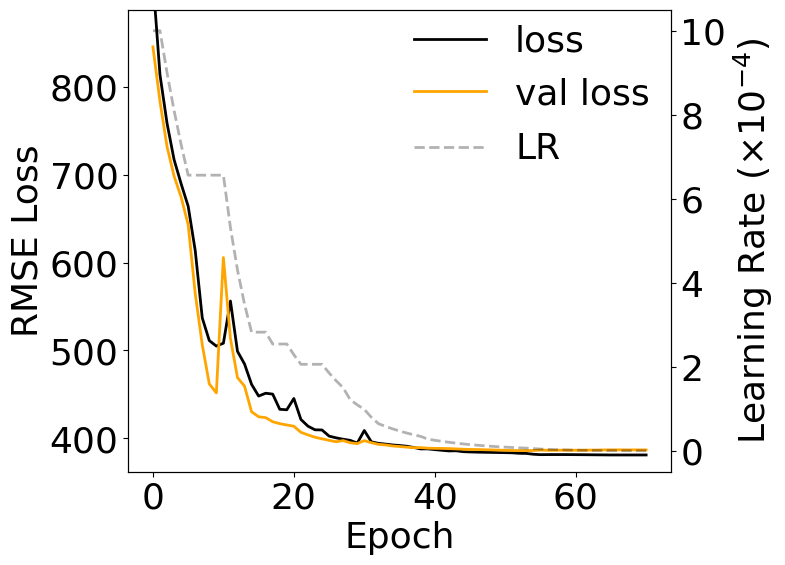

In [406]:
history = {'loss': epoch_losses, 'val_loss': epoch_vlosses, 'lr': epoch_lr}
np.savez(model_path+name+'_history_id', **history)

np.savez(model_path+name+'_cst', mean_PS_mean = mean_mean.cpu().numpy(), mean_PS_std = mean_std.cpu().numpy(), 
         noisy_PS_mean = noisy_mean.cpu().numpy(), noisy_PS_std = noisy_std.cpu().numpy(),
         std_mean = std_mean.cpu().numpy(), std_std = std_std.cpu().numpy())
plot_hist(history, np.floor(min(epoch_losses)*10000.)/10000.*0.95, np.ceil(max(epoch_vlosses)*1000.)/1000.*1.05)

In [244]:
model = Autoencoder(base_channel_size = 64, latent_dim = 256, num_input_channels = 1, 
                    num_output_channels = 2)
#print(model)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
criterion = loss_KL()

In [ ]:
epochs = 1000
epoch = 0
scheduler1 = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
scheduler2 = lr_scheduler.StepLR(optimizer, step_size = 1, gamma=0.1)
scheduler3 = lr_scheduler.StepLR(optimizer, step_size = 1, gamma=0.2)
model.train()
all_losses = []
epoch_losses = []

all_vlosses = []
epoch_vlosses = []
epoch_lr = []

all_percents = []

optimize = 'vloss'
while epoch < epochs:
    tmp = []
    model.float()
    for batch_num in range(nbatches):
        optimizer.zero_grad()
        x = torch.Tensor(X_train[batch_num*batch_size:(batch_num+1)*batch_size])
        y = torch.Tensor(Y_train[batch_num*batch_size:(batch_num+1)*batch_size,...])

        x = x.to(DEVICE).float()
        y = y.to(DEVICE).float()
        #full_x = full_x.to(DEVICE).float()
        output = model(x[:,np.newaxis,...])
        loss = criterion(output, y)
        loss.backward()
        
        tmp.append(loss.item())
        all_losses.append(loss.item())
        
        optimizer.step()
        

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        vtmp = []
        for batch_num_valid in range(nbatches_valid):
            x = torch.Tensor(X_valid[batch_num_valid*batch_size:(batch_num_valid+1)*batch_size])
            y = torch.Tensor(Y_valid[batch_num_valid*batch_size:(batch_num_valid+1)*batch_size,...])
            x = x.to(DEVICE).float()
            y = y.to(DEVICE).float()

            output = model(x[:,np.newaxis,...])
            vloss = criterion(output, y)
            all_vlosses.append(vloss)
            vtmp.append(vloss)
        epoch_vlosses.append(torch.median(torch.Tensor(vtmp)).detach().cpu().numpy())
        #print(output.min(), ' vs ', x.min(), output.max(), ' vs ', x.max())
    
    epoch_losses.append(np.median(tmp))
    epoch_lr.append(optimizer.param_groups[0]["lr"])
    if epoch == 0:
        mloss = torch.median(torch.Tensor(tmp))
        vloss = torch.median(torch.Tensor(vtmp))
        lrr = optimizer.param_groups[0]["lr"]
        print(f'Epoch {epoch:d} | Loss {mloss:.4E} | Val Loss {vloss:.4E} | lr {lrr:.4E}')
    if epoch > 0 and optimizer.param_groups[0]["lr"] >= 1e-12:
        if optimize.lower() == 'loss':
            this_loss = epoch_losses[-1]
            prev_loss = np.min(epoch_losses[:-1])
            percent = (prev_loss - this_loss)/this_loss * 100.
        else:
            this_loss = epoch_vlosses[-1]
            prev_loss = np.min(epoch_vlosses[:-1])
            percent = (prev_loss - this_loss)/this_loss * 100.
        all_percents.append(percent)
        mloss = torch.median(torch.Tensor(tmp))
        vloss = torch.median(torch.Tensor(vtmp))
        lrr = optimizer.param_groups[0]["lr"]
        if optimize.lower() == 'loss':
            print(f'Epoch {epoch:d} | Loss {mloss:.4E} | Val Loss {vloss:.4E} | lr {lrr:.4E} | Loss FE {percent/100.:.2%} ')
        else:
            print(f'Epoch {epoch:d} | Loss {mloss:.4E} | Val Loss {vloss:.4E} | lr {lrr:.4E} | VLoss FE {percent/100.:.2%} ')
        if percent < 1e-4 and percent > 0:
            scheduler2.step()
            scheduler1.step()
        elif percent < 1e-2 and percent > 0:
            scheduler2.step()
        elif percent < 0:
            # final plateau check
            this_loss = epoch_vlosses[-1]
            prev_loss = np.array(epoch_vlosses[-10:])
            plateau_percent = np.mean(abs((this_loss - prev_loss)/this_loss) * 100.)
            if epoch > 10 and plateau_percent < 1e-3:
                # Stop if if plateaued for 10 epochs
                epoch = epochs
            elif epoch > 4 and np.any(np.array(all_percents[-3:-1]) < 0):
                scheduler2.step()
                scheduler1.step()
            else:
                scheduler1.step()
    if optimizer.param_groups[0]["lr"] < 1e-12:
        epoch = epochs
    epoch += 1
    if (epoch > 5 and this_loss <= np.min(epoch_vlosses)) or epoch == epochs - 1:
        torch.save(model.state_dict(), model_path+name+'_KL')

Epoch 0 | Loss 3.8648E+02 | Val Loss 2.8139E+02 | lr 1.0000E-03
Epoch 1 | Loss 2.0171E+02 | Val Loss 2.2030E+02 | lr 1.0000E-03 | VLoss FE 27.73% 
Epoch 2 | Loss 2.3063E+02 | Val Loss 2.3220E+02 | lr 1.0000E-03 | VLoss FE -5.12% 
Epoch 3 | Loss 1.6691E+02 | Val Loss 1.7434E+02 | lr 9.0000E-04 | VLoss FE 26.36% 
Epoch 4 | Loss 1.5783E+02 | Val Loss 1.7512E+02 | lr 9.0000E-04 | VLoss FE -0.45% 
Epoch 5 | Loss 1.4961E+02 | Val Loss 1.5333E+02 | lr 8.1000E-04 | VLoss FE 13.70% 


In [105]:
Y_train.shape

(113126, 16, 16, 2)

In [107]:
foo = np.zeros((Y_train.shape[0], 2, 16,16))
foo[:,0,...] = Y_train[...,0]
foo[:,1,...] = Y_train[...,1]

In [113]:
loss_KL()(torch.Tensor(foo).to(device), torch.Tensor(Y_train).to(device))

tensor(128., device='cuda:0')

In [30]:
history = {'loss': epoch_losses, 'val_loss': epoch_vlosses, 'lr': epoch_lr}

In [31]:
np.savez(model_path+name+'_history_KL', **history)
#np.savez(model_path+name+'_cst', PS_mean = PS_mean, PS_std = PS_std)

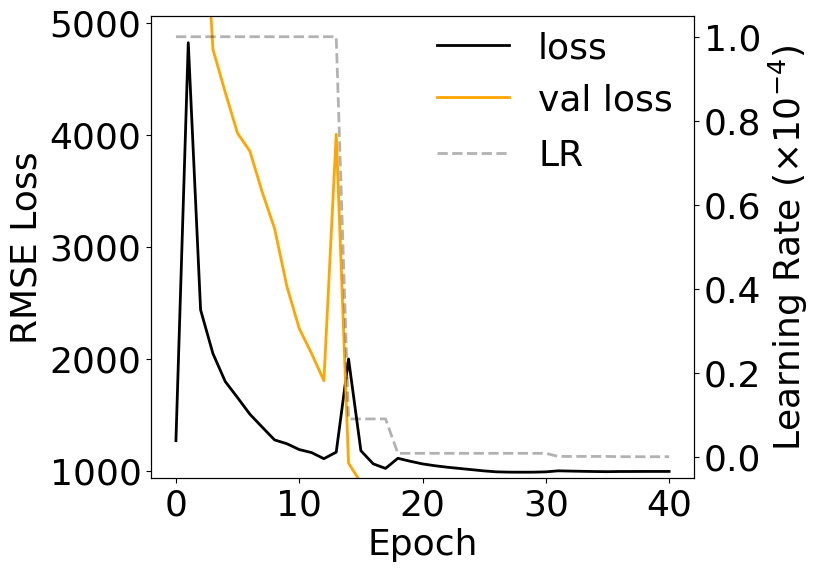

In [32]:
plot_hist(history, np.floor(min(epoch_losses)*10000.)/10000.*0.95, np.ceil(max(epoch_losses)*1000.)/1000.*1.05)

In [133]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [101]:
epochs = 1000
epoch = 0
scheduler1 = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
scheduler2 = lr_scheduler.StepLR(optimizer, step_size = 1, gamma=0.9)
model.train()
all_losses = []
epoch_losses = []

all_vlosses = []
epoch_vlosses = []
epoch_lr = []
while epoch < epochs:
    tmp = []
    for batch_num in range(nbatches):
        optimizer.zero_grad()
        x = torch.Tensor(X_train[batch_num*batch_size:(batch_num+1)*batch_size])
        y = torch.Tensor(Y_train[batch_num*batch_size:(batch_num+1)*batch_size,...])
        #var = torch.Tensor(Y_train[batch_num*batch_size:(batch_num+1)*batch_size][:, np.newaxis,...,1])
        #full_x = torch.cat((y,var), axis = 1)
        x = x.to(DEVICE).float()
        y = y.to(DEVICE).float()
        #full_x = full_x.to(DEVICE).float()
        output = model(x[:,np.newaxis,...])
        loss = criterion(output, y)
        loss.backward()
        
        tmp.append(loss.item())
        all_losses.append(loss.item())
        
        optimizer.step()

        #if batch_num % 100 == 0:
        #    print('\tEpoch %d | Batch %d | Loss %.4E' % (epoch, batch_num, loss.item()))
    
    
    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        vtmp = []
        for batch_num_valid in range(nbatches_valid):
            x = torch.Tensor(X_valid[batch_num_valid*batch_size:(batch_num_valid+1)*batch_size])
            y = torch.Tensor(Y_valid[batch_num_valid*batch_size:(batch_num_valid+1)*batch_size,...])
            x = x.to(DEVICE).float()
            y = y.to(DEVICE).float()

            x = x.to(DEVICE).float()
            output = model(x[:,np.newaxis,...])#model(y[:,np.newaxis,...,0])
            vloss = criterion(output, y)
            all_vlosses.append(vloss)
            vtmp.append(vloss)
        epoch_vlosses.append(torch.median(torch.Tensor(vtmp)).detach().cpu().numpy())
        #print(output.min(), ' vs ', x.min(), output.max(), ' vs ', x.max())
    
    epoch_losses.append(np.median(tmp))
    epoch_lr.append(optimizer.param_groups[0]["lr"])
    if epoch == 0:
        mloss = torch.median(torch.Tensor(tmp))
        vloss = torch.median(torch.Tensor(vtmp))
        lrr = optimizer.param_groups[0]["lr"]
        print(f'Epoch {epoch:d} | Loss {mloss:.4E} | Val Loss {vloss:.4E} | lr {lrr:.4E}')
    if epoch > 0 and optimizer.param_groups[0]["lr"] >= 1e-12:
        this_loss = epoch_vlosses[-1]
        prev_loss = np.min(epoch_vlosses[:-1])
        percent = (prev_loss - this_loss)/this_loss * 100.
        mloss = torch.median(torch.Tensor(tmp))
        vloss = torch.median(torch.Tensor(vtmp))
        lrr = optimizer.param_groups[0]["lr"]
        print(f'Epoch {epoch:d} | Loss {mloss:.4E} | Val Loss {vloss:.4E} | lr {lrr:.4E} | VLoss FE {percent/100.:.2%} ')
        if percent < 1e-2 and percent > 0:
            scheduler2.step()
        elif percent < 1e-4 and percent > 0:
            scheduler2.step()
            scheduler1.step()
        elif percent < 0:
            # final plateau check
            this_loss = epoch_vlosses[-1]
            if percent < -11:
                if epoch > 10:
                    prev_loss = np.array(epoch_vlosses[-10:])
                    percent = np.mean(abs((this_loss - prev_loss)/this_loss) * 100.)
                    if percent < 1e-3:
                        # Stop if if plateaued for 10 epochs
                        epoch = epochs
                    else:
                        scheduler1.step()
            else:
                scheduler2.step()
                scheduler1.step()
    if optimizer.param_groups[0]["lr"] < 1e-12:
        epoch = epochs
    epoch += 1
    if (epoch > 5 and this_loss <= np.min(epoch_vlosses)) or epoch == epochs - 1:
        torch.save(model.state_dict(), model_path+name+'_4_KL')

Epoch 0 | Loss 1.3844E+03 | Val Loss 1.5043E+03 | lr 1.0000E-06
Epoch 1 | Loss 1.3937E+03 | Val Loss 1.4929E+03 | lr 1.0000E-06 | VLoss FE 0.77% 
Epoch 2 | Loss 1.3930E+03 | Val Loss 1.4904E+03 | lr 1.0000E-06 | VLoss FE 0.16% 
Epoch 3 | Loss 1.3871E+03 | Val Loss 1.4875E+03 | lr 1.0000E-06 | VLoss FE 0.20% 
Epoch 4 | Loss 1.3751E+03 | Val Loss 1.4935E+03 | lr 1.0000E-06 | VLoss FE -0.40% 
Epoch 5 | Loss 1.3717E+03 | Val Loss 1.4951E+03 | lr 8.1000E-07 | VLoss FE -0.51% 
Epoch 6 | Loss 1.3605E+03 | Val Loss 1.4703E+03 | lr 6.5610E-07 | VLoss FE 1.16% 
Epoch 7 | Loss 1.3497E+03 | Val Loss 1.4741E+03 | lr 6.5610E-07 | VLoss FE -0.26% 
Epoch 8 | Loss 1.3556E+03 | Val Loss 1.4360E+03 | lr 5.3144E-07 | VLoss FE 2.39% 
Epoch 9 | Loss 1.3481E+03 | Val Loss 1.4416E+03 | lr 5.3144E-07 | VLoss FE -0.38% 
Epoch 10 | Loss 1.3530E+03 | Val Loss 1.4001E+03 | lr 4.3047E-07 | VLoss FE 2.56% 
Epoch 11 | Loss 1.3431E+03 | Val Loss 1.3976E+03 | lr 4.3047E-07 | VLoss FE 0.18% 
Epoch 12 | Loss 1.3380E+03 |